**Guojing Wu** | UNI: gw2383 | *2019-10-01*

# E6893 BIg Data Analytics Homework1: Clustering, Classification, and Spark MLlib

## Problem 1. Iterative K-means clustering on Spark

Below is the implementation of K-means on Spark

In [42]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg # calculating L1 and L2 distance
import time # calculate computing time
import pandas as pd
from sklearn.manifold import TSNE # for dimensionality reduction
import random

# Macros.
MAX_ITER = 20
DATA_PATH = "gs://big_data_hw/hw1/data.txt"
C1_PATH = "gs://big_data_hw/hw1/c1.txt"
C2_PATH = "gs://big_data_hw/hw1/c2.txt"

# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point, only an array
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid, only one number
    """
    closest_c = min([(i, linalg.norm(p - c, norm))
                    for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    return closest_c

# K-means clustering
def kmeans(data, centroids, norm=2):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        list: a list of centroids corresponding to each points
        cost: a list of costs through iteration
    """
    # iterative k-means
    # st = time.time()
    cost = []
    
    for t in range(MAX_ITER):
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))
        combo = data.map(lambda point: (closest(point, centroids, norm), (point, 1))).cache()
        
        #within cluser cost and running time
        costById = combo.map(lambda x: (x[0], linalg.norm(x[1][0] - centroids[x[0]], norm))) \
        .reduceByKey(lambda x, y: x + y).collect()
        cost.append(sum([costById[i][1] for i in range(len(costById))]))
        # print("Iteration %d, within cluster cost: %.2f (time: %.2f)" %
        #               (t + 1, sum([cost[i][1] for i in range(len(cost))]), time.time() - st))
        # st = time.time()
        
        # Re-compute cluster center
        # For each cluster center (key), aggregate its values
        # by summing up points and count
        reduce1 = combo.reduceByKey(lambda a, b: ([a[0][i]+b[0][i] for i in range(len(a[0]))], a[1]+b[1]))
        
        # Average the points for each centroid: divide sum of points by count
        map1 = reduce1.sortByKey().map(lambda x: [x[1][0][i] / x[1][1] for i in range(len(x[1][0]))])
        
        # Use collect() to turn RDD into list
        centroids = map1.collect()
        
    centroIndex = data.map(lambda point: closest(point, centroids, norm)).collect()
        
    return cost, centroIndex

def main(norm):
    random.seed(0)
    # Spark settings
    conf = SparkConf()
    sc = SparkContext.getOrCreate(conf=conf)

    # Load the data, cache this since we're accessing this each iteration
    data = sc.textFile(DATA_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).cache()
    # Load the initial centroids c1, split into a list of np arrays
    centroids1 = sc.textFile(C1_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).collect()
    # Load the initial centroids c2, split into a list of np arrays
    centroids2 = sc.textFile(C2_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).collect()
    
    # calculate the cost and the final central point index
    cost1, centroIndex1 = kmeans(data, centroids1, norm)
    cost2, centroIndex2 = kmeans(data, centroids2, norm)
    
    # demensionality reduction
    data_np = np.array(data.collect())
    data_embedded = TSNE(n_components=2).fit_transform(data_np)
    vis_x = data_embedded[:,0]
    vis_y = data_embedded[:,1]
    
    plt.figure(figsize=(10,8))
    # plot for cost
    plt.subplot(2,2,1)
    plt.plot(range(20), cost1)
    plt.title('Cost Result using c1 and L%d distance' % (norm))
    plt.grid(True)
    plt.subplot(2,2,2)
    plt.plot(range(20), cost2)
    plt.title('Cost Result using c2 and L%d distance' % (norm))
    plt.grid(True)
    
    # plot for clustering result
    plt.subplot(2,2,3)
    plt.scatter(vis_x, vis_y, c = centroIndex1)
    plt.title('t-SNE result of c1 and L%d distance' % (norm))
    plt.subplot(2,2,4)
    plt.scatter(vis_x, vis_y, c = centroIndex2)
    plt.title('t-SNE result of c2 and L%d distance' % (norm))
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, 
                        right=0.95, hspace=0.35, wspace=0.35)
    
    plt.show()
    
    sc.stop()

### (1) Run clustering on data.txt​ with​ c1.txt​ and ​c2.txt​ as initial centroids and use L1 distance as similarity measurement. Compute and plot the ​within-cluster cost​ for each iteration. You’ll need to submit two graphs here. (20%)

By using the code above, we plot the cost for C1 and C2 initial central points, together with visualization results by using t-SNE to reduce the dimension to 2D

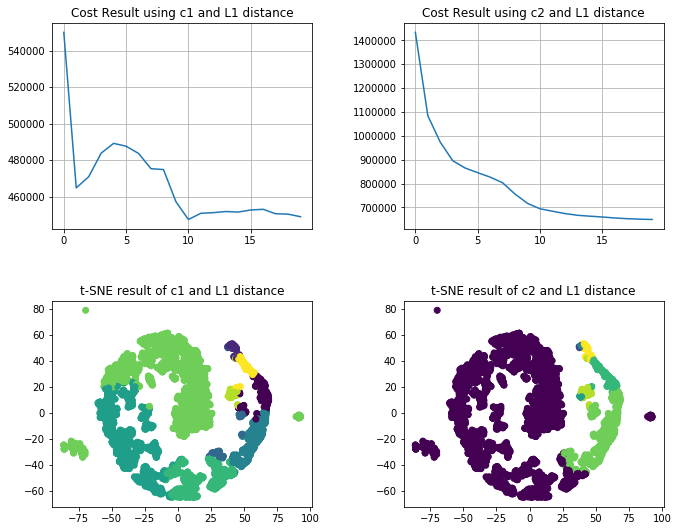

In [44]:
main(1)

### (2) Run clustering on ​data.txt​ with​ c1.txt​ and ​c2.txt​ as initial centroids and use L2 distance as similarity measurement. Compute and plot the ​within-cluster cost​ for each iteration. You’ll need to submit two graphs here. (20%)

See the answer below, together with q(3)

### (3)  t-SNE​ is a dimensionality reduction method particularly suitable for visualization of high-dimensional data. Visualize your clustering assignment result of (2) by reducing the dimension to a 2D space. You’ll need to submit two graphs here. (10%)

We plot the cost for C1 and C2 initial central points, together with visualization results by using t-SNE to reduce the dimension to 2D

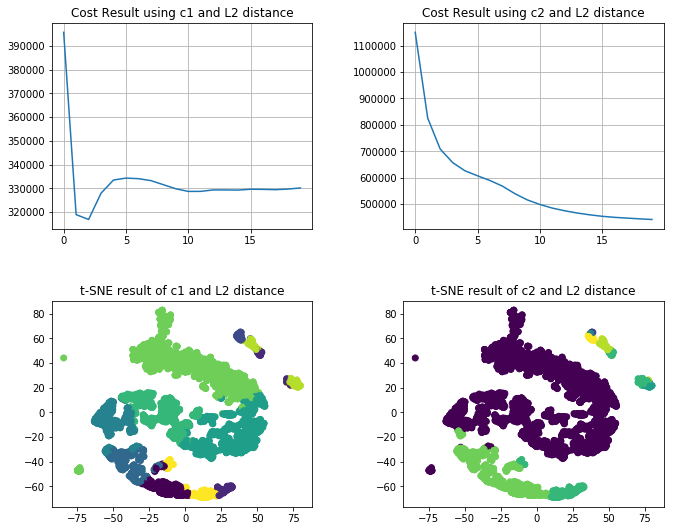

In [45]:
main(2)

### (4) For L2 and L1 distance, are random initialization of K-means using ​c1.txt​ better than initialization using ​c2.txt​ in terms of cost? Explain your reasoning. (5%)

No, although from the above plots we could see that using c1 will get a better cost than c2 in the end, but we only got 20 iterations. If the we increase the `MAX_ITER`, the cost by using c2 will eventually be lower than by using c1. 

Because random initialization sometimes can results in creating centroids in such a way that they are clumped together in space. Then in the end we'll have several clusters cramped tightly, and make other clusters more sparse, which will result in a higher cost.

### (5) What is the time complexity of the iterative K-means? (5%)

Assume we have:

* `k` clusters

* `p` data points, with `d` dimensions 

* `n` maximum iterations

Then:

* for calculating the distance between each points and centroids: O(n) = pdk

* for choosing the closest centroids by using quick sort: O(n) = p * klog(k)

* for recomputing the controids: O(n) = pd

So altogether, O(n) = n(pdk + pklog(k) + pd) = np(dk + klog(k) + d)

## Problem 2. Binary classification with Spark MLlib

### (a) Data loading

In [1]:
# create SparkSession and load data
from pyspark.sql import SparkSession
ADULT_PATH = "gs://big_data_hw/hw1/adult.data.csv"

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
    
df = spark.read.csv(ADULT_PATH, inferSchema = True)
# rename each column
oldColumns = df.columns
newColumns = ("age", "workclass", "fnlwgt", "education", 
              "education_num", "marital_status", "occupation", 
              "relationship", "race", "sex", "capital_gain", 
              "capital_loss", "hours_per_week", "native_country", "income")

df = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), xrange(len(oldColumns)), df)

### (b) Data preprocessing

In [35]:
# preprocessing and model building
from pyspark.ml import Pipeline 
from pyspark.ml.feature import * 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt

In [5]:
# piping the preprocess and regression
categorical_variables = ['workclass', 'education', 'marital_status', 
                         'occupation', 'relationship', 'race', 'sex', 'native_country']
continuous_variables = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

indexers = [StringIndexer(inputCol=column, 
                          outputCol=column+"_index") for column in categorical_variables]
encoder = OneHotEncoderEstimator(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers]
)
assembler = VectorAssembler(
    inputCols=encoder.getOutputCols() + continuous_variables,
    outputCol="features"
)
response = StringIndexer(inputCol='income', outputCol='label')
preprocess = Pipeline(stages=indexers + [encoder, assembler, response])

# split data into 70% training and 30% testing and set the seed to 100
train, test = df.randomSplit([0.7, 0.3], seed = 100)
pre_model = preprocess.fit(train)
train = pre_model.transform(train)
test = pre_model.transform(test)

### (c) Modelling

In [6]:
# fit train data and predict on test data
lr = LogisticRegression(maxIter=10, featuresCol='features', labelCol='label')
model = lr.fit(train)
prediction = model.transform(test)

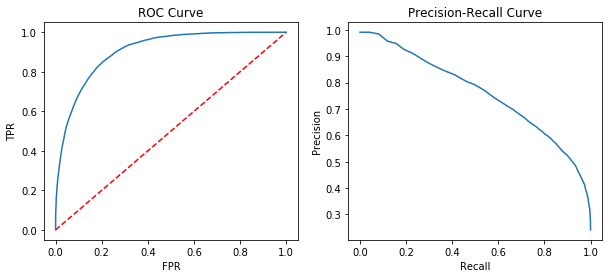

In [14]:
# ROC for training data
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

plt.subplot(1,2,2)
pr = model.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve')

plt.show()

### (d) Evaluation

In [49]:
# testing AUC and accuracy and confusion matrix
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(prediction)
print("%s is: %.6f \n" % (evaluator.getMetricName(), evaluator.evaluate(prediction)))

acc = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
print("%s is: %.6f \n" % (acc.getMetricName(), acc.evaluate(prediction)))

predictionAndLabels = prediction.select('prediction', 'label').rdd
metrics = MulticlassMetrics(predictionAndLabels)
print("confusion matrix is: ")
print(metrics.confusionMatrix())

areaUnderROC is: 0.902738 

accuracy is: 0.848401 

confusion matrix is: 
DenseMatrix([[6860.,  530.],
             [ 944., 1389.]])


In [16]:
spark.stop()